In [17]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [18]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score ,classification_report ,roc_curve, auc ,precision_recall_curve


import os
import cv2
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import  preprocess_input

In [20]:
train_path ='/kaggle/input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train'
test_path = '/kaggle/input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid'

**Train Data**

In [21]:
img_size=100

train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=50,
    zoom_range=0.2,
    rescale=1/255.0,
    preprocessing_function=None,
    validation_split=0.1,
).flow_from_directory(train_path,
                      batch_size=64,
                      target_size=(img_size, img_size),
                      subset="training",
                      color_mode='rgb', 
                      class_mode='categorical', 
                      shuffle=True)

Found 63282 images belonging to 38 classes.


In [22]:
labels=list(train_generator.class_indices.keys())
labels

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

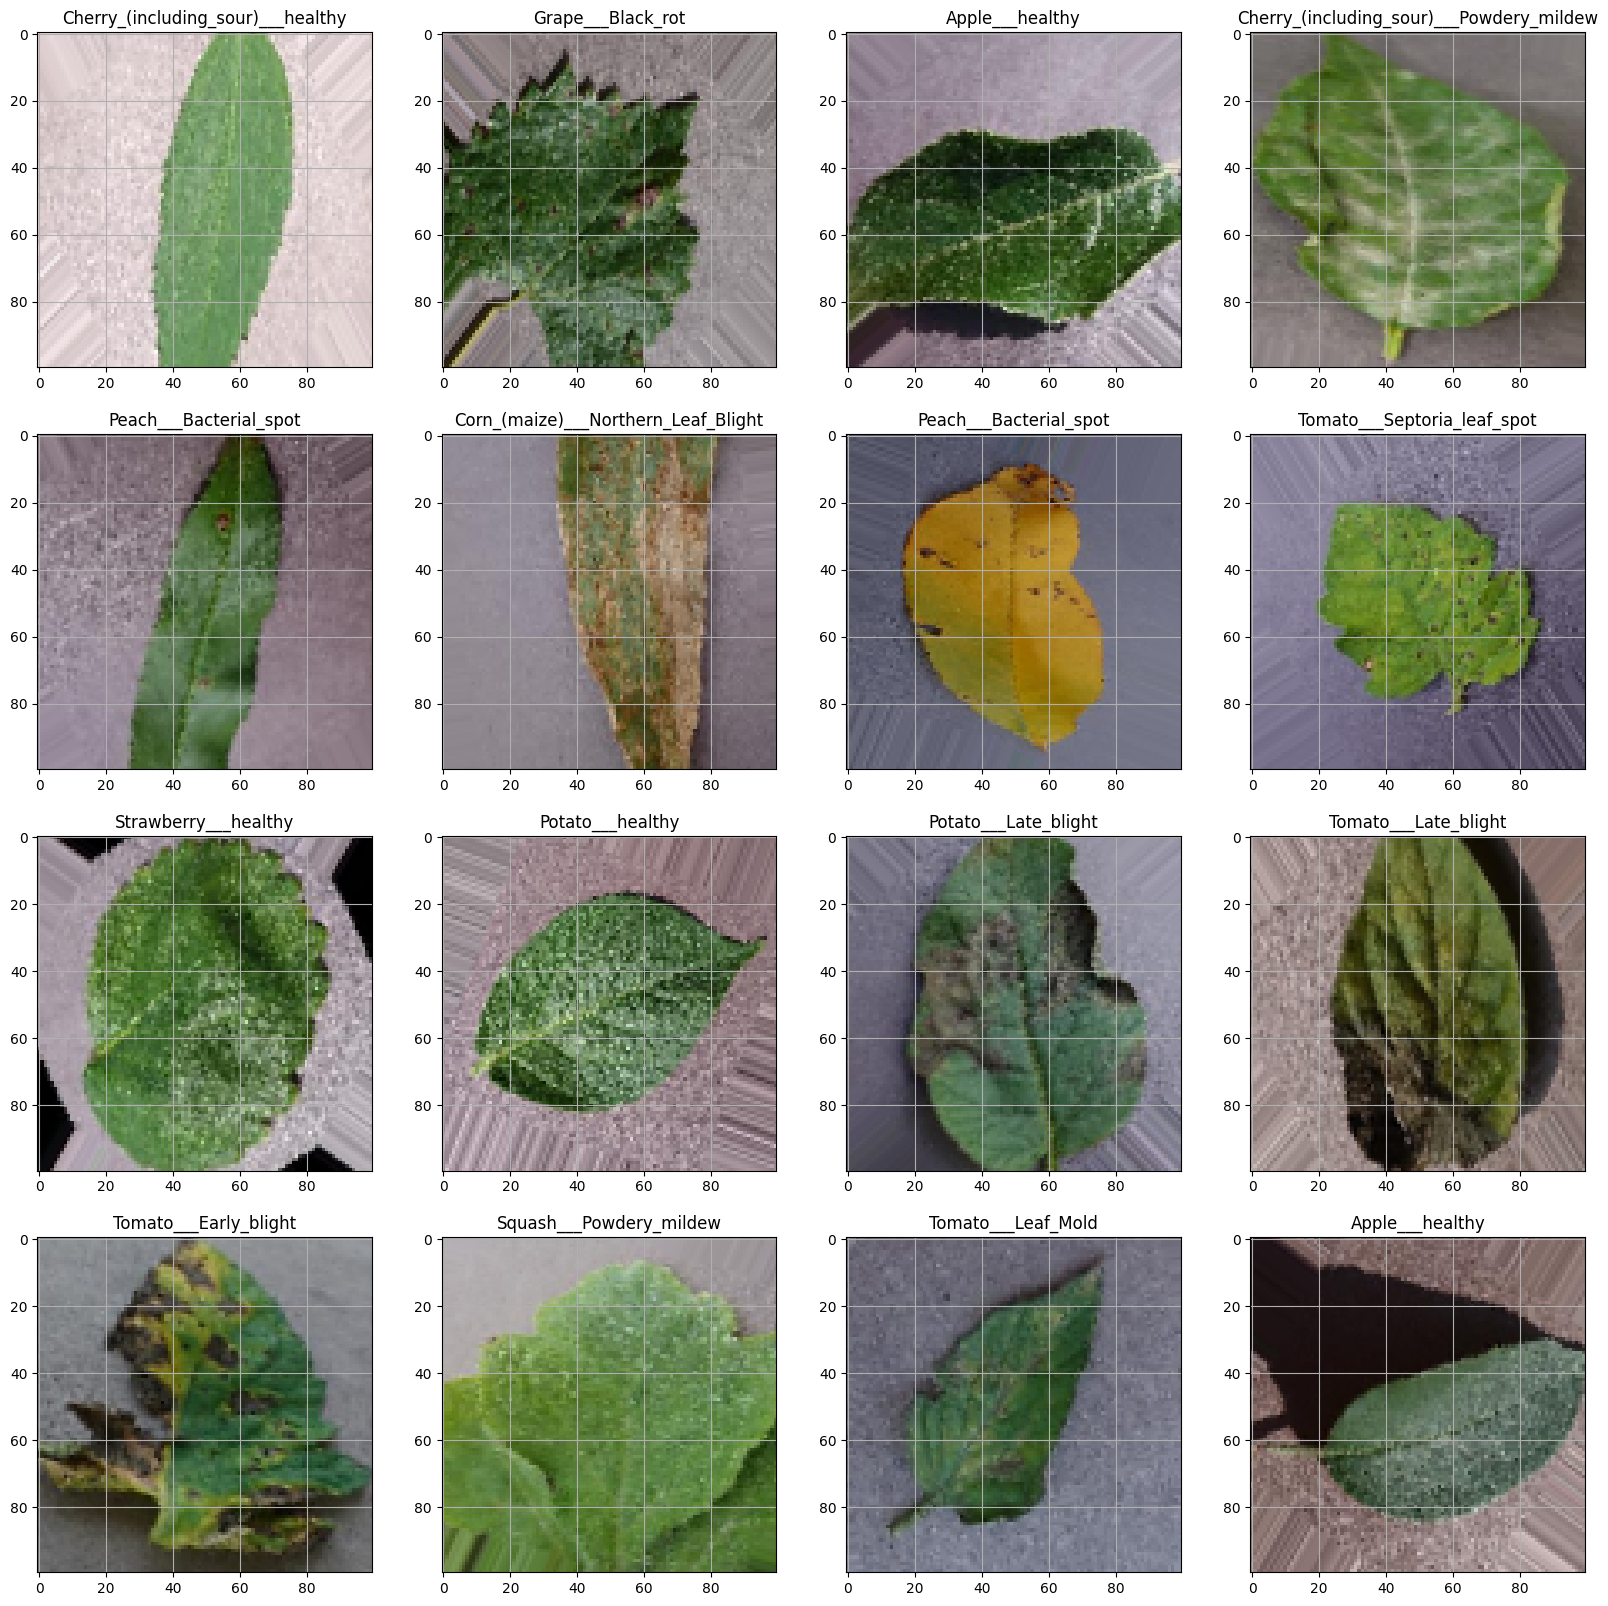

In [23]:
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(labels[np.where(y_batch[i]==1)[0][0]])   # when y is categorical
        # plt.title(classes[int(y_batch[i])])   # when y is binary or sparse
        plt.grid(None)
    # show the plot
    plt.show()
    break

**Validation Data**

In [24]:
validation_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=50,  # Apply same augmentations
    zoom_range=0.2,
    rescale=1/255.0,
    validation_split=0.1,  # Same validation split
).flow_from_directory(train_path,
                      batch_size=64,
                      target_size=(img_size, img_size),
                      subset="validation",  # Access validation data (10%)
                      color_mode='rgb',
                      class_mode='categorical',
                      shuffle=True)

Found 7013 images belonging to 38 classes.


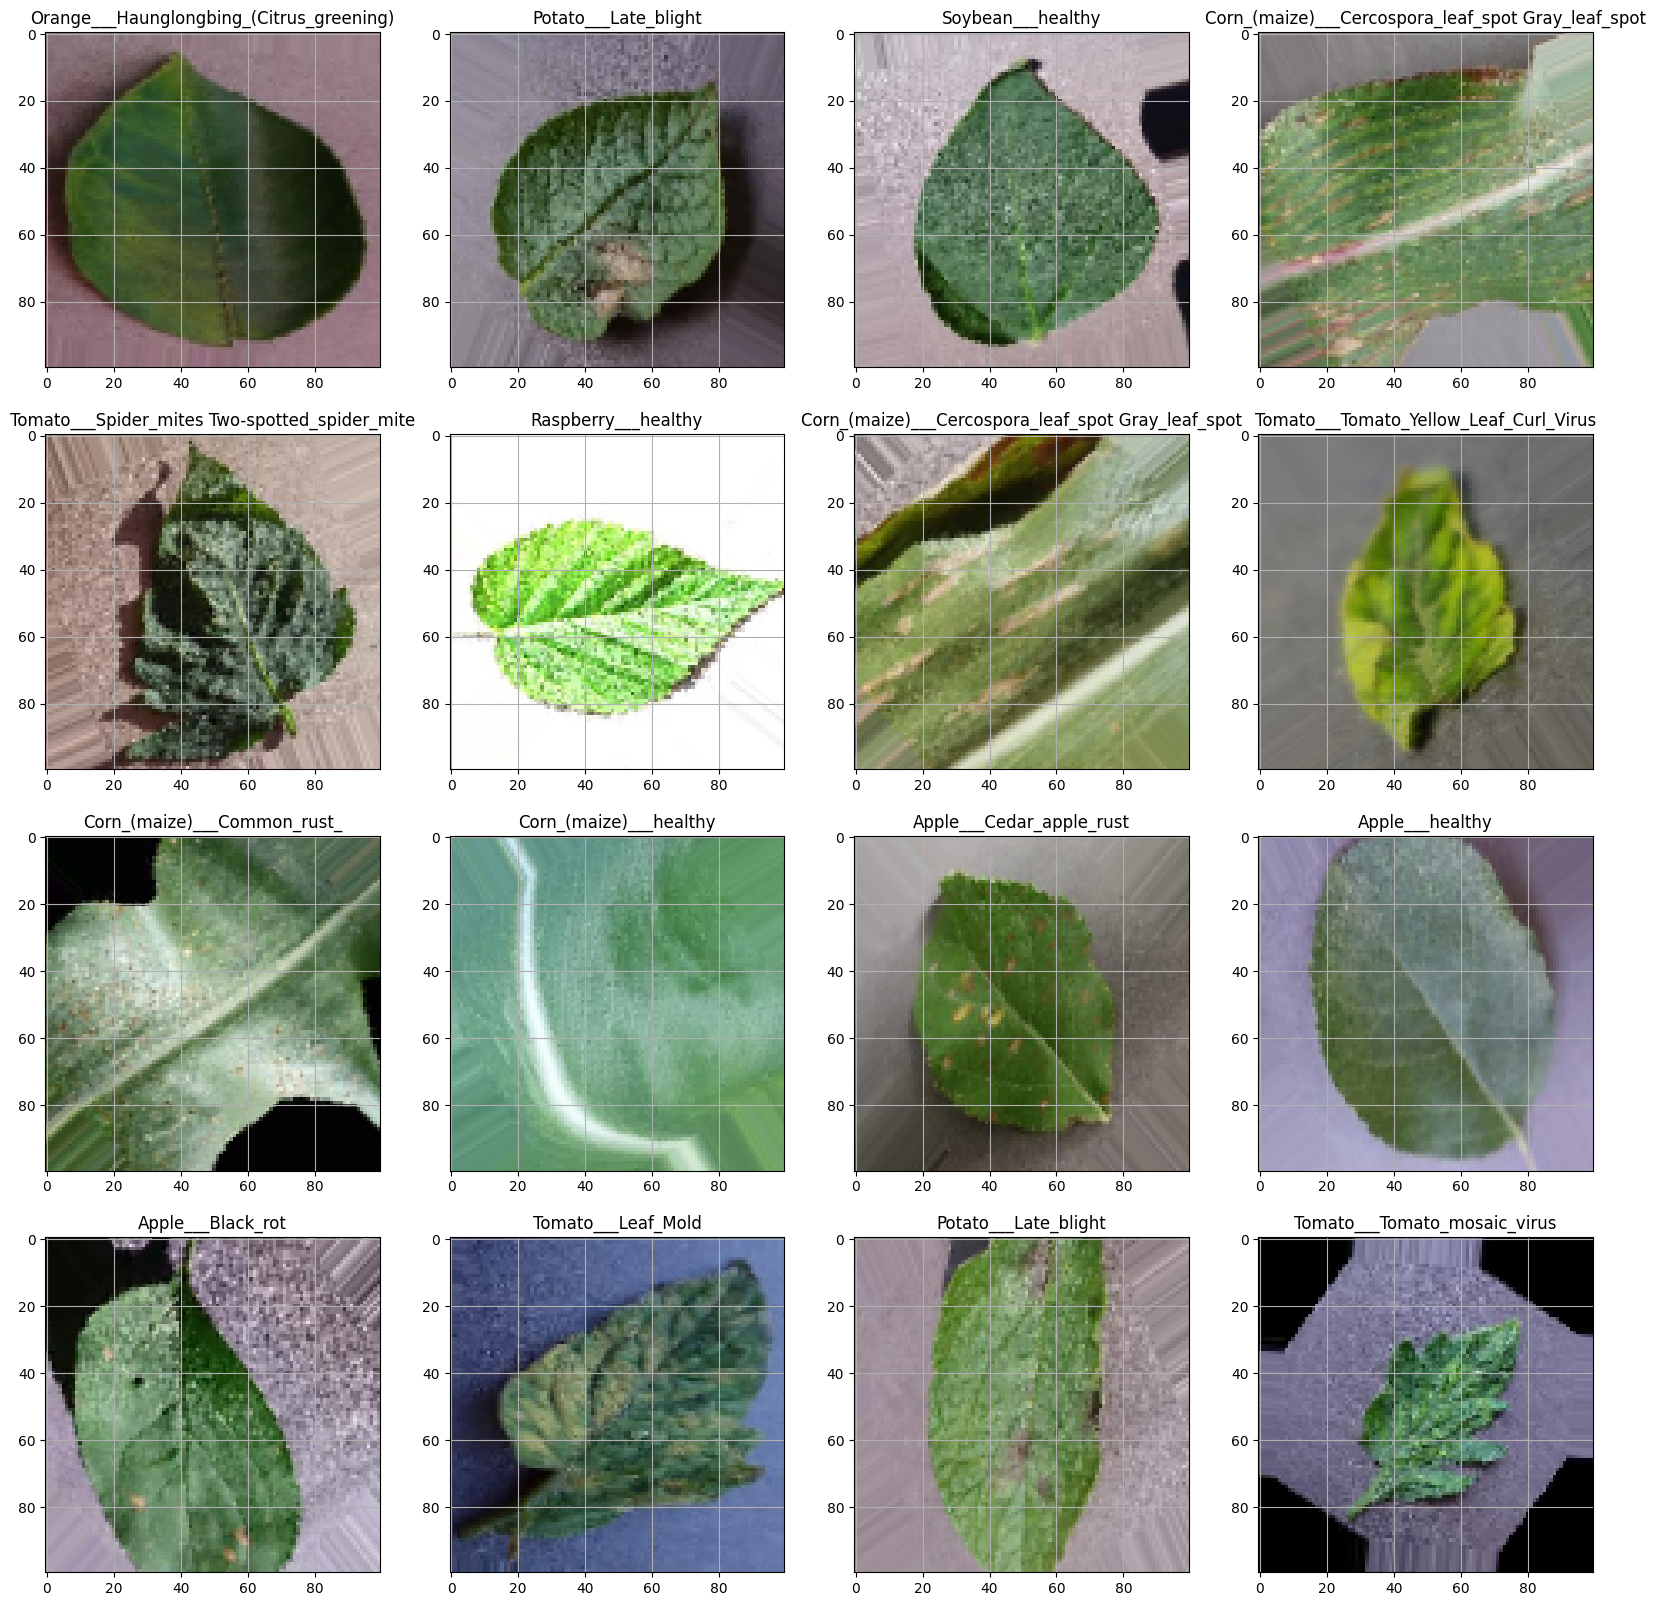

In [25]:
plt.figure(figsize=(20,20))
for X_batch, y_batch in validation_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(labels[np.where(y_batch[i]==1)[0][0]])   # when y is categorical
        # plt.title(classes[int(y_batch[i])])   # when y is binary or sparse
        plt.grid(None)
    # show the plot
    plt.show()
    break

**Test Data**

In [26]:
test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=50,
    zoom_range=0.2,
    rescale=1/255.0,
    preprocessing_function=None,
).flow_from_directory(test_path,
                      batch_size=64,
                      target_size=(img_size, img_size),
                      color_mode='rgb',
                      class_mode='categorical',
                      shuffle=False)

Found 17572 images belonging to 38 classes.


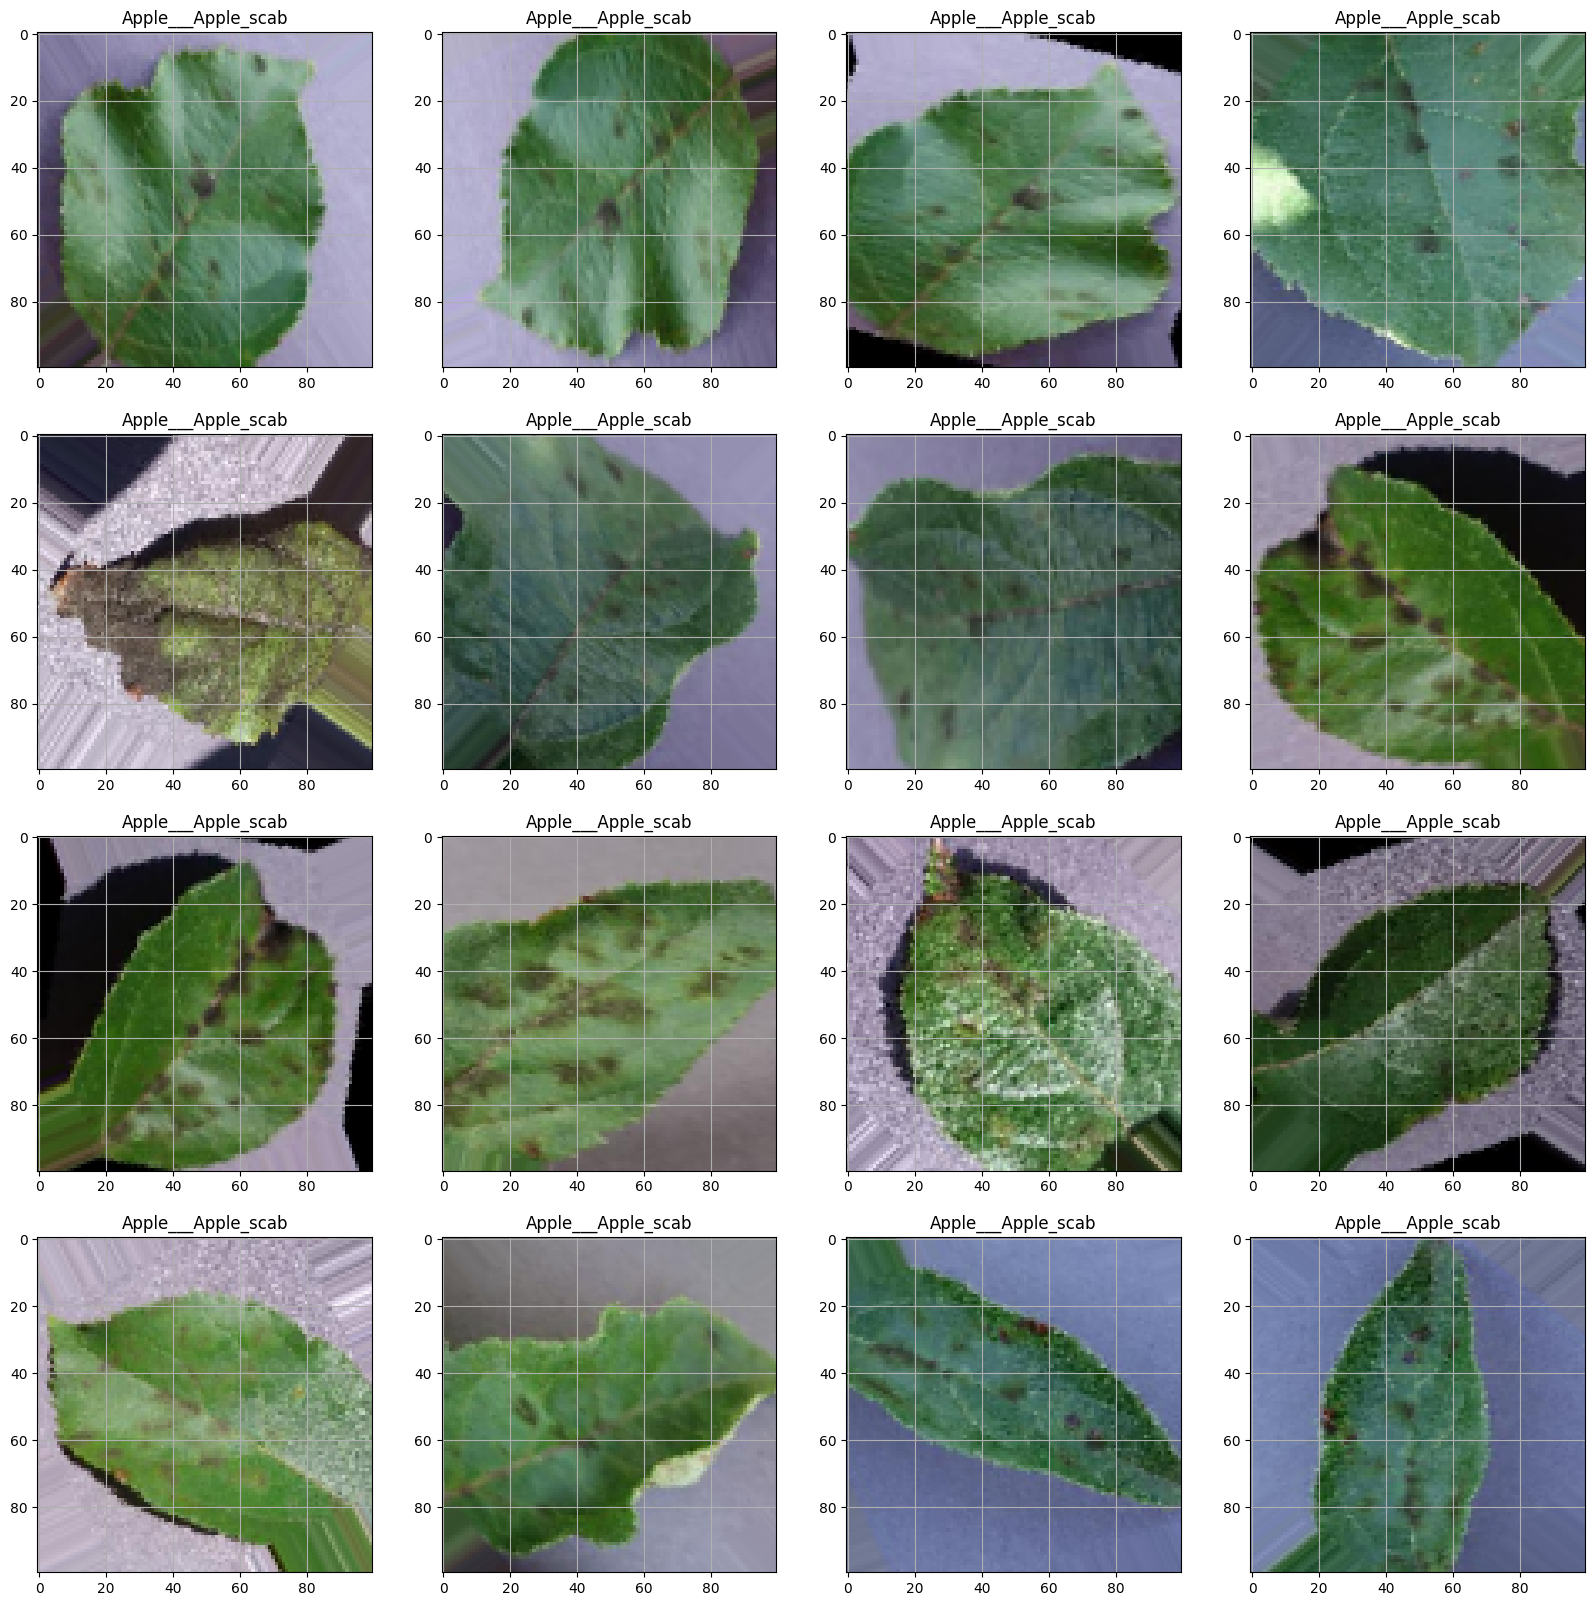

In [27]:
plt.figure(figsize=(20,20))
for X_batch, y_batch in test_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(labels[np.where(y_batch[i]==1)[0][0]])   # when y is categorical
        # plt.title(classes[int(y_batch[i])])   # when y is binary or sparse
        plt.grid(None)
    # show the plot
    plt.show()
    break

## Simple CNN Model

In [28]:
# size = (img_size, img_size, 3)
# num_classes = len(labels)


# CNN_model = Sequential([

#     Conv2D(64, (3, 3), activation='relu', input_shape=size),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
    
#     Conv2D(128, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Conv2D(256, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.3),
#     Conv2D(512, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.5),
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dense(num_classes, activation='softmax')
#     ])


# # Compile the model
# CNN_model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy', 'precision', 'recall'])

# # Define early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# CNN_model.summary()

In [29]:
size = (img_size, img_size, 3)
num_classes = len(labels)


CNN_model = Sequential([

    Conv2D(32, (3, 3), activation='relu', input_shape=size),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
    ])


# Compile the model
CNN_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print(CNN_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,609,894 (6.14 MB)

 Trainable params: 1,609,894 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

None


In [30]:
history_CNN = CNN_model.fit(train_generator,
                    epochs = 30,
                    batch_size=64,
                    validation_data = validation_generator,
                    callbacks = early_stopping
                    )



CNN_model.save('CNN_model.h5')

Epoch 1/30
989/989 ━━━━━━━━━━━━━━━━━━━━ 284s 279ms/step - accuracy: 0.1452 - loss: 3.1071 - precision: 0.5887 - recall: 0.0325 - val_accuracy: 0.5776 - val_loss: 1.3860 - val_precision: 0.8450 - val_recall: 0.3009
Epoch 2/30
989/989 ━━━━━━━━━━━━━━━━━━━━ 290s 291ms/step - accuracy: 0.5230 - loss: 1.5379 - precision: 0.7394 - recall: 0.3328 - val_accuracy: 0.6983 - val_loss: 0.9832 - val_precision: 0.8403 - val_recall: 0.5508
Epoch 3/30
989/989 ━━━━━━━━━━━━━━━━━━━━ 290s 292ms/step - accuracy: 0.6522 - loss: 1.1148 - precision: 0.7925 - recall: 0.5165 - val_accuracy: 0.8099 - val_loss: 0.6157 - val_precision: 0.8803 - val_recall: 0.7311
Epoch 4/30
989/989 ━━━━━━━━━━━━━━━━━━━━ 300s 302ms/step - accuracy: 0.7139 - loss: 0.8988 - precision: 0.8198 - recall: 0.6175 - val_accuracy: 0.8277 - val_loss: 0.5599 - val_precision: 0.8899 - val_recall: 0.7609
Epoch 5/30
989/989 ━━━━━━━━━━━━━━━━━━━━ 286s 287ms/step - accuracy: 0.7613 - loss: 0.7531 - precision: 0.8429 - recall: 0.6846 - val_accuracy: 0

In [37]:
# Evaluate the model
train_loss, train_accuracy, train_precision, train_recall= CNN_model.evaluate(train_generator)
test_loss, test_accuracy, test_precision, test_recall= CNN_model.evaluate(test_generator)

989/989 ━━━━━━━━━━━━━━━━━━━━ 297s 301ms/step - accuracy: 0.9708 - loss: 0.0895 - precision: 0.9749 - recall: 0.9673
275/275 ━━━━━━━━━━━━━━━━━━━━ 82s 299ms/step - accuracy: 0.9690 - loss: 0.1007 - precision: 0.9725 - recall: 0.9668


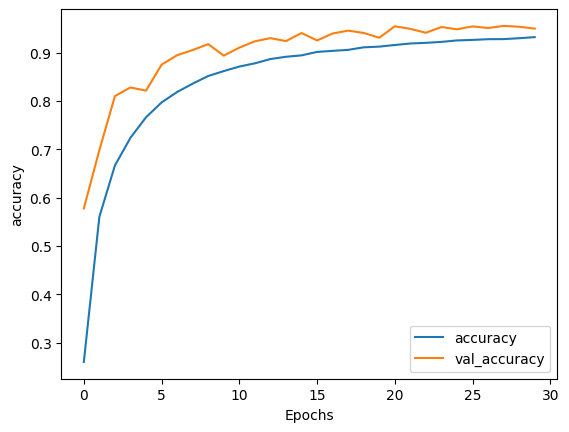

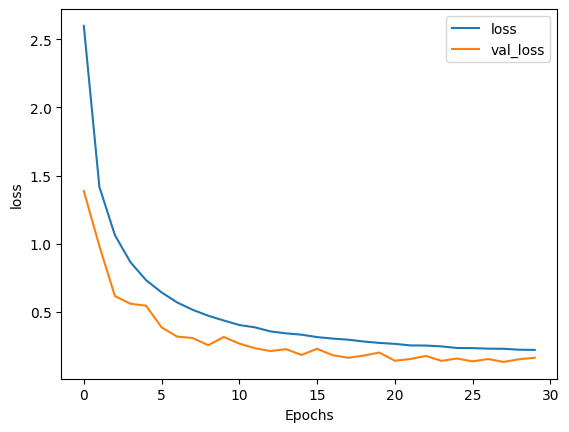

In [32]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+ string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string,'val_'+ string ])
  plt.show()

plot_graphs(history_CNN, 'accuracy')
plot_graphs(history_CNN, 'loss')

**Confusion Matrix**

275/275 ━━━━━━━━━━━━━━━━━━━━ 63s 230ms/step


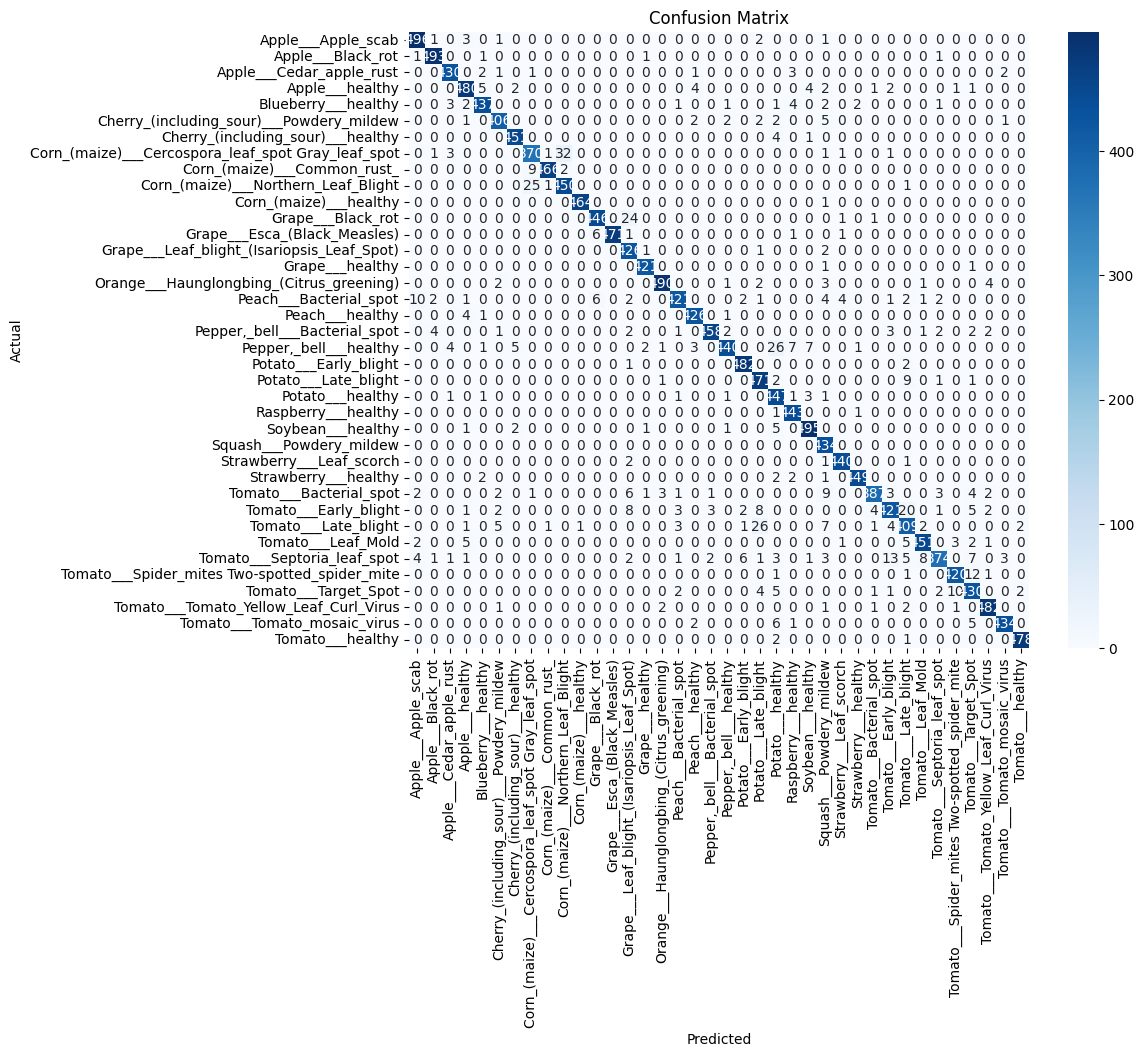

In [40]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


y_test_pred = CNN_model.predict(test_generator)
y_test_pred_class = np.argmax(y_test_pred, axis=1) 


y_test_true = test_generator.classes


labels = list(test_generator.class_indices.keys())  # Class names


conf_matrix = confusion_matrix(y_test_true, y_test_pred_class)

#  Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Classification Report**

In [41]:
class_report = classification_report(y_test_true, y_test_pred_class, target_names=labels)
print('Classification Report:\n', class_report)

Classification Report:
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab       0.96      0.98      0.97       504
                                 Apple___Black_rot       0.98      0.99      0.99       497
                          Apple___Cedar_apple_rust       0.97      0.98      0.98       440
                                   Apple___healthy       0.96      0.96      0.96       502
                               Blueberry___healthy       0.97      0.96      0.97       454
          Cherry_(including_sour)___Powdery_mildew       0.96      0.96      0.96       421
                 Cherry_(including_sour)___healthy       0.98      0.99      0.98       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.91      0.90      0.91       410
                       Corn_(maize)___Common_rust_       0.99      0.98      0.99       477
               Corn_(maize)___Northern_Leaf_Blight     

**Save results in dataframe**

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_train_pred = CNN_model.predict(train_generator)
y_test_pred = CNN_model.predict(test_generator)

y_train_pred_class = np.argmax(y_train_pred, axis=1)
y_test_pred_class = np.argmax(y_test_pred, axis=1)

# Get the true class labels
y_train_true = train_generator.classes
y_test_true = test_generator.classes


f1_train = f1_score(y_train_true, y_train_pred_class, average='weighted')
f1_test = f1_score(y_test_true, y_test_pred_class, average='weighted')



989/989 ━━━━━━━━━━━━━━━━━━━━ 268s 271ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 64s 232ms/step


In [39]:
data = {
    'model': ['CNN'],
    'Accuracy train': [train_accuracy],
    'Accuracy test': [test_accuracy],
    'Precision train': [train_precision],
    'Precision test': [test_precision],
    'Recall train': [train_recall],
    'Recall test': [test_recall],
    'F1-score train': [f1_train],
    'F1-score test': [f1_test]
}


metrics_df = pd.DataFrame(data)
metrics_df

model  Accuracy train  Accuracy test  Precision train  Precision test  \
0   CNN        0.971161       0.960448         0.975246        0.965721   

   Recall train  Recall test  F1-score train  F1-score test  
0      0.967495     0.957148        0.026849       0.960477

## EfficientNet

In [43]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model



size = (img_size, img_size, 3)
num_classes = len(labels)

# Load EfficientNetB0 without top layers
base_model = EfficientNetB0(include_top=False, input_shape=size, weights='imagenet')

# Add custom top layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)  
EfficientNet_model = Model(inputs=base_model.input, outputs=x)

# Compile model
EfficientNet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])

EfficientNet_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 100, 100,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 100, 100,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 100, 100,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 101, 101,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 50, 50,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 50, 50,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 50, 50,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 50, 50,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 50, 50,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 50, 50,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 50, 50,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 50, 50,    │        512 │ block1a_se_excit

 Total params: 6,676,041 (25.47 MB)

 Trainable params: 6,634,018 (25.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [44]:
# Train the model
EfficientNet_model.fit(train_generator, validation_data=validation_generator, epochs=10)

EfficientNet_model.save('EfficientNet_model.h5')

Epoch 1/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 478s 403ms/step - accuracy: 0.8060 - loss: 0.7135 - precision: 0.8738 - recall: 0.7691 - val_accuracy: 0.8473 - val_loss: 0.6713 - val_precision: 0.8693 - val_recall: 0.8362
Epoch 2/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 326s 328ms/step - accuracy: 0.9526 - loss: 0.1747 - precision: 0.9590 - recall: 0.9472 - val_accuracy: 0.8008 - val_loss: 0.8985 - val_precision: 0.8250 - val_recall: 0.7833
Epoch 3/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 287s 289ms/step - accuracy: 0.9575 - loss: 0.1472 - precision: 0.9638 - recall: 0.9532 - val_accuracy: 0.9373 - val_loss: 0.2531 - val_precision: 0.9455 - val_recall: 0.9298
Epoch 4/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 316s 283ms/step - accuracy: 0.9698 - loss: 0.1054 - precision: 0.9732 - recall: 0.9666 - val_accuracy: 0.9418 - val_loss: 0.2681 - val_precision: 0.9471 - val_recall: 0.9388
Epoch 5/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 280s 281ms/step - accuracy: 0.9683 - loss: 0.1136 - precision: 0.9724 - recall: 0.9659 - val_accuracy: 0

In [45]:
# Evaluate the model
train_loss, train_accuracy, train_precision, train_recall= EfficientNet_model.evaluate(train_generator)
test_loss, test_accuracy, test_precision, test_recall= EfficientNet_model.evaluate(test_generator)

989/989 ━━━━━━━━━━━━━━━━━━━━ 248s 251ms/step - accuracy: 0.9839 - loss: 0.0639 - precision: 0.9855 - recall: 0.9821
275/275 ━━━━━━━━━━━━━━━━━━━━ 75s 272ms/step - accuracy: 0.9839 - loss: 0.0687 - precision: 0.9863 - recall: 0.9826


In [48]:
# def plot_graphs(history, string):
#   plt.plot(history.history[string])
#   plt.plot(history.history['val_'+ string])
#   plt.xlabel('Epochs')
#   plt.ylabel(string)
#   plt.legend([string,'val_'+ string ])
#   plt.show()

# plot_graphs(EfficientNet_model, 'accuracy')
# plot_graphs(EfficientNet_model, 'loss')

**Confusion Matrix**

275/275 ━━━━━━━━━━━━━━━━━━━━ 73s 248ms/step


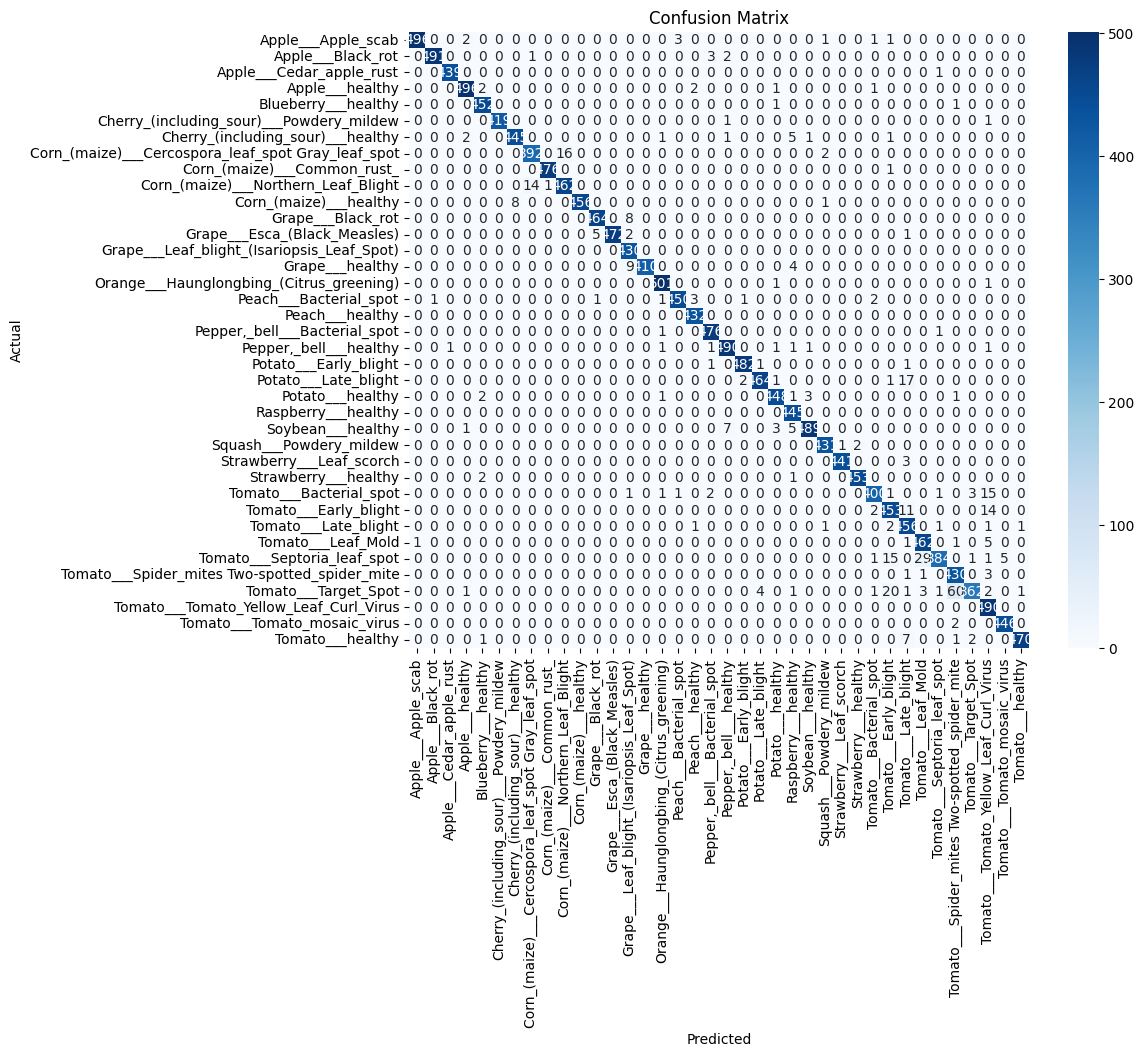

In [47]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


y_test_pred = EfficientNet_model.predict(test_generator)
y_test_pred_class = np.argmax(y_test_pred, axis=1) 


y_test_true = test_generator.classes


labels = list(test_generator.class_indices.keys())  # Class names


conf_matrix = confusion_matrix(y_test_true, y_test_pred_class)

#  Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Classification Report**

In [49]:
class_report = classification_report(y_test_true, y_test_pred_class, target_names=labels)
print('Classification Report:\n', class_report)

Classification Report:
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.98      0.99       504
                                 Apple___Black_rot       1.00      0.99      0.99       497
                          Apple___Cedar_apple_rust       1.00      1.00      1.00       440
                                   Apple___healthy       0.99      0.99      0.99       502
                               Blueberry___healthy       0.98      1.00      0.99       454
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       421
                 Cherry_(including_sour)___healthy       0.98      0.98      0.98       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.96      0.96      0.96       410
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       477
               Corn_(maize)___Northern_Leaf_Blight     

**Save Results**

In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_train_pred = EfficientNet_model.predict(train_generator)
y_test_pred = EfficientNet_model.predict(test_generator)

y_train_pred_class = np.argmax(y_train_pred, axis=1)
y_test_pred_class = np.argmax(y_test_pred, axis=1)

# Get the true class labels
y_train_true = train_generator.classes
y_test_true = test_generator.classes


f1_train = f1_score(y_train_true, y_train_pred_class, average='weighted')
f1_test = f1_score(y_test_true, y_test_pred_class, average='weighted')



989/989 ━━━━━━━━━━━━━━━━━━━━ 249s 251ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 68s 248ms/step


In [53]:
EfficientNet_results = {
    'model': 'EfficientNet',
    'Accuracy train': np.around(train_accuracy, 3),
    'Accuracy test': np.around(test_accuracy, 3),
    'Precision train': np.around(train_precision, 3),
    'Precision test': np.around(test_precision, 3),
    'Recall train': np.around(train_recall, 3),
    'Recall test': np.around(test_recall, 3),
    'F1-score train': np.around(f1_train, 3),
    'F1-score test': np.around(f1_test, 3)
}


metrics_df.loc[len(metrics_df)] = EfficientNet_results
metrics_df

model Accuracy train Accuracy test Precision train Precision test  \
0           CNN       0.971161      0.960448        0.975246       0.965721   
1  EfficientNet          0.983         0.976           0.985          0.979   

  Recall train Recall test F1-score train F1-score test  
0     0.967495    0.957148       0.026849      0.960477  
1        0.981       0.974          0.027         0.978

##  ResNet

In [55]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model


size = (img_size, img_size, 3)
num_classes = len(labels)

# Load ResNet50 without top layers
base_model = ResNet50(include_top=False, input_shape=size, weights='imagenet')

# Add custom top layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)
ResNet = Model(inputs=base_model.input, outputs=x)

# Compile model
ResNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])

ResNet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 106, 106,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 50, 50,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 50, 50,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 50, 50,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 52, 52,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 25, 25,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 25, 25,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 25, 25,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 25, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 25, 25,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 25, 25,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 25, 25,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 25, 25,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 25, 25,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 25, 25,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 25, 25,    │      1,024 │ conv2_block1_3_c

 Total params: 27,787,046 (106.00 MB)

 Trainable params: 27,733,926 (105.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [56]:
history_ResNet =ResNet.fit(train_generator, validation_data=validation_generator, epochs=10)
ResNet.save('ResNet.h5')

Epoch 1/10
  1/989 ━━━━━━━━━━━━━━━━━━━━ 14:50:49 54s/step - accuracy: 0.0312 - loss: 5.0258 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1729697516.022979     125 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_25', 16 bytes spill stores, 16 bytes spill loads



342/989 ━━━━━━━━━━━━━━━━━━━━ 3:23 315ms/step - accuracy: 0.5087 - loss: 2.0814 - precision: 0.7262 - recall: 0.3963

I0000 00:00:1729697623.547738     126 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_25', 16 bytes spill stores, 16 bytes spill loads



989/989 ━━━━━━━━━━━━━━━━━━━━ 358s 308ms/step - accuracy: 0.6589 - loss: 1.3453 - precision: 0.8125 - recall: 0.5766 - val_accuracy: 0.1520 - val_loss: 7.8578 - val_precision: 0.1794 - val_recall: 0.1362
Epoch 2/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 268s 269ms/step - accuracy: 0.8500 - loss: 0.4978 - precision: 0.9027 - recall: 0.8244 - val_accuracy: 0.3321 - val_loss: 3.2238 - val_precision: 0.3850 - val_recall: 0.2909
Epoch 3/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 268s 270ms/step - accuracy: 0.8406 - loss: 0.5288 - precision: 0.8957 - recall: 0.8099 - val_accuracy: 0.8054 - val_loss: 0.7187 - val_precision: 0.8376 - val_recall: 0.7912
Epoch 4/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 268s 269ms/step - accuracy: 0.9282 - loss: 0.2301 - precision: 0.9543 - recall: 0.9202 - val_accuracy: 0.8119 - val_loss: 0.7178 - val_precision: 0.8371 - val_recall: 0.7960
Epoch 5/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 267s 268ms/step - accuracy: 0.9070 - loss: 0.2989 - precision: 0.9384 - recall: 0.8917 - val_accuracy: 0.7654 - val

In [57]:
# Evaluate the model
train_loss, train_accuracy, train_precision, train_recall= ResNet.evaluate(train_generator)
test_loss, test_accuracy, test_precision, test_recall= ResNet.evaluate(test_generator)

989/989 ━━━━━━━━━━━━━━━━━━━━ 241s 243ms/step - accuracy: 0.9473 - loss: 0.1710 - precision: 0.9663 - recall: 0.9406
275/275 ━━━━━━━━━━━━━━━━━━━━ 71s 258ms/step - accuracy: 0.9433 - loss: 0.1842 - precision: 0.9637 - recall: 0.9374


In [60]:
test_loss, test_accuracy, test_precision, test_recall

(0.21402983367443085,
 0.9358638525009155,
 0.9564248323440552,
 0.9280673861503601)

In [59]:
train_loss, train_accuracy, train_precision, train_recall

(0.17008157074451447,
 0.9476628303527832,
 0.9657509922981262,
 0.9410890936851501)

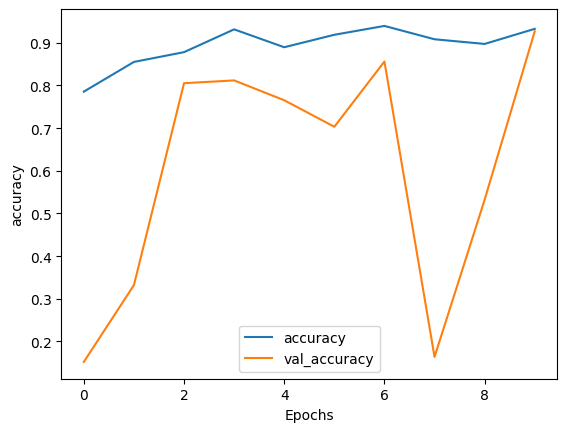

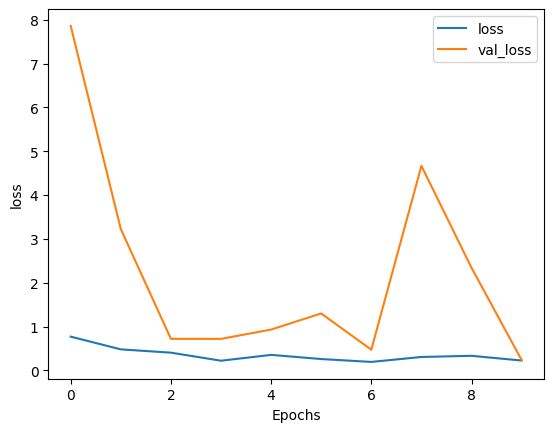

In [58]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+ string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string,'val_'+ string ])
  plt.show()

plot_graphs(history_ResNet, 'accuracy')
plot_graphs(history_ResNet, 'loss')

**Confusion Matrix**

275/275 ━━━━━━━━━━━━━━━━━━━━ 70s 243ms/step


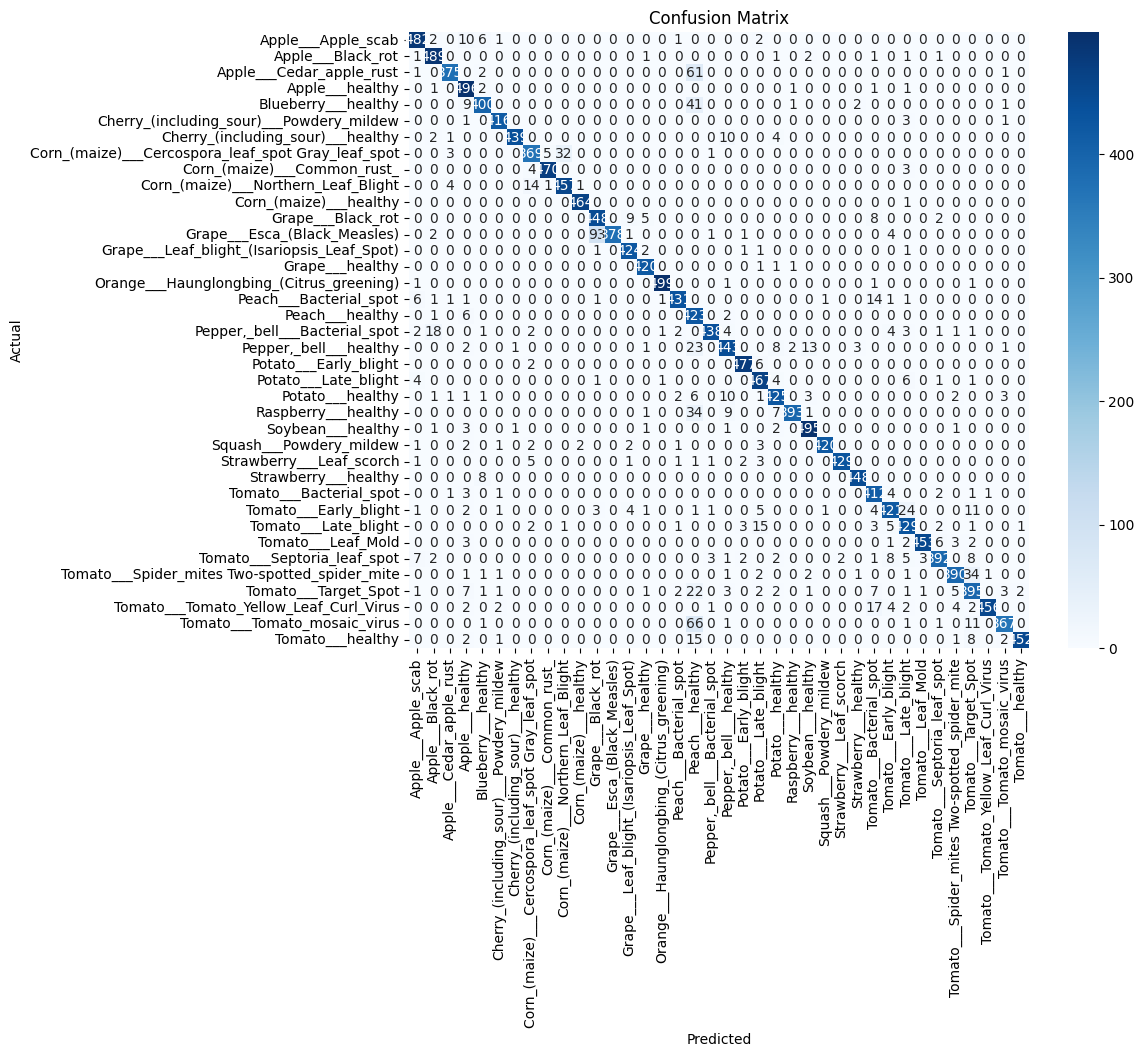

In [61]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


y_test_pred = ResNet.predict(test_generator)
y_test_pred_class = np.argmax(y_test_pred, axis=1) 


y_test_true = test_generator.classes


labels = list(test_generator.class_indices.keys())  # Class names


conf_matrix = confusion_matrix(y_test_true, y_test_pred_class)

#  Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Classification Report**

In [62]:
class_report = classification_report(y_test_true, y_test_pred_class, target_names=labels)
print('Classification Report:\n', class_report)

Classification Report:
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab       0.95      0.96      0.95       504
                                 Apple___Black_rot       0.94      0.98      0.96       497
                          Apple___Cedar_apple_rust       0.97      0.85      0.91       440
                                   Apple___healthy       0.90      0.99      0.94       502
                               Blueberry___healthy       0.95      0.88      0.91       454
          Cherry_(including_sour)___Powdery_mildew       0.98      0.99      0.98       421
                 Cherry_(including_sour)___healthy       1.00      0.96      0.98       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.92      0.90      0.91       410
                       Corn_(maize)___Common_rust_       0.99      0.99      0.99       477
               Corn_(maize)___Northern_Leaf_Blight     

**Save Results**

In [63]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_train_pred = ResNet.predict(train_generator)
y_test_pred = ResNet.predict(test_generator)

y_train_pred_class = np.argmax(y_train_pred, axis=1)
y_test_pred_class = np.argmax(y_test_pred, axis=1)

# Get the true class labels
y_train_true = train_generator.classes
y_test_true = test_generator.classes


f1_train = f1_score(y_train_true, y_train_pred_class, average='weighted')
f1_test = f1_score(y_test_true, y_test_pred_class, average='weighted')

989/989 ━━━━━━━━━━━━━━━━━━━━ 240s 242ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 65s 236ms/step


In [64]:
ResNet_results = {
    'model': 'ResNet',
    'Accuracy train': np.around(train_accuracy, 3),
    'Accuracy test': np.around(test_accuracy, 3),
    'Precision train': np.around(train_precision, 3),
    'Precision test': np.around(test_precision, 3),
    'Recall train': np.around(train_recall, 3),
    'Recall test': np.around(test_recall, 3),
    'F1-score train': np.around(f1_train, 3),
    'F1-score test': np.around(f1_test, 3)
}


metrics_df.loc[len(metrics_df)] = ResNet_results
metrics_df

model Accuracy train Accuracy test Precision train Precision test  \
0           CNN       0.971161      0.960448        0.975246       0.965721   
1  EfficientNet          0.983         0.976           0.985          0.979   
2        ResNet          0.948         0.936           0.966          0.956   

  Recall train Recall test F1-score train F1-score test  
0     0.967495    0.957148       0.026849      0.960477  
1        0.981       0.974          0.027         0.978  
2        0.941       0.928          0.027         0.939

## VGG19

In [74]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model



size = (img_size, img_size, 3)
num_classes = len(labels)

base_model = VGG19(include_top=False, input_shape=size, weights='imagenet')


base_model.trainable = False

# Add custom top layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)
VGG19_model = Model(inputs=base_model.input, outputs=x)


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Compile model with a lower learning rate
VGG19_model.compile(optimizer='adam', 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy', 'precision', 'recall'])

# Print model summary
VGG19_model.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,02

 Total params: 21,224,486 (80.96 MB)

 Trainable params: 1,199,462 (4.58 MB)

 Non-trainable params: 20,025,024 (76.39 MB)

In [75]:
# Train the model
history_VGG19 = VGG19_model.fit(train_generator, validation_data=validation_generator, epochs=20, callbacks=[early_stopping])
VGG19_model.save('VGG19_model.h5')

Epoch 1/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 327s 322ms/step - accuracy: 0.3503 - loss: 2.3871 - precision: 0.6238 - recall: 0.1534 - val_accuracy: 0.6941 - val_loss: 0.9968 - val_precision: 0.8514 - val_recall: 0.5448
Epoch 2/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 258s 259ms/step - accuracy: 0.6005 - loss: 1.3015 - precision: 0.7675 - recall: 0.4359 - val_accuracy: 0.7513 - val_loss: 0.8016 - val_precision: 0.8691 - val_recall: 0.6250
Epoch 3/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 256s 257ms/step - accuracy: 0.6403 - loss: 1.1748 - precision: 0.7767 - recall: 0.4992 - val_accuracy: 0.7659 - val_loss: 0.7417 - val_precision: 0.8655 - val_recall: 0.6672
Epoch 4/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 261s 262ms/step - accuracy: 0.6576 - loss: 1.1027 - precision: 0.7869 - recall: 0.5334 - val_accuracy: 0.7649 - val_loss: 0.7512 - val_precision: 0.8592 - val_recall: 0.6746
Epoch 5/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 259s 260ms/step - accuracy: 0.6662 - loss: 1.0692 - precision: 0.7928 - recall: 0.5497 - val_accuracy: 0

In [77]:
# Evaluate the model
train_loss, train_accuracy, train_precision, train_recall= VGG19_model.evaluate(train_generator)
test_loss, test_accuracy, test_precision, test_recall= VGG19_model.evaluate(test_generator)

989/989 ━━━━━━━━━━━━━━━━━━━━ 290s 293ms/step - accuracy: 0.8254 - loss: 0.5441 - precision: 0.8924 - recall: 0.7526
275/275 ━━━━━━━━━━━━━━━━━━━━ 85s 308ms/step - accuracy: 0.8191 - loss: 0.5796 - precision: 0.8865 - recall: 0.7539


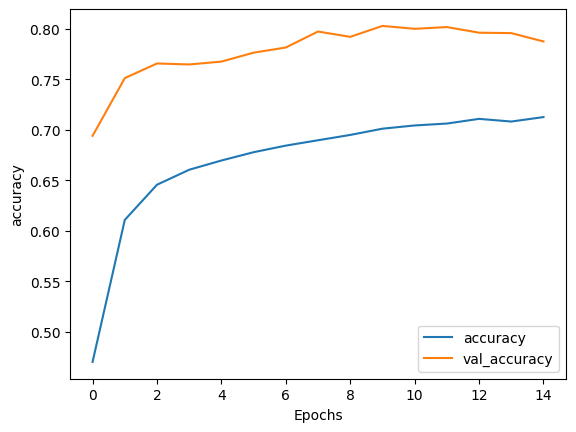

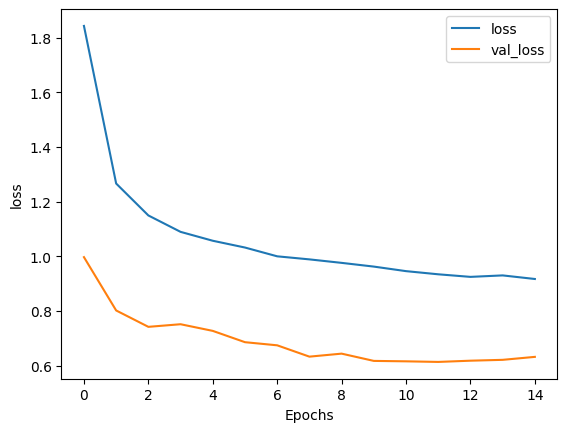

In [78]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+ string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string,'val_'+ string ])
  plt.show()

plot_graphs(history_VGG19, 'accuracy')
plot_graphs(history_VGG19, 'loss')

**Confusion Matrix**

275/275 ━━━━━━━━━━━━━━━━━━━━ 65s 232ms/step


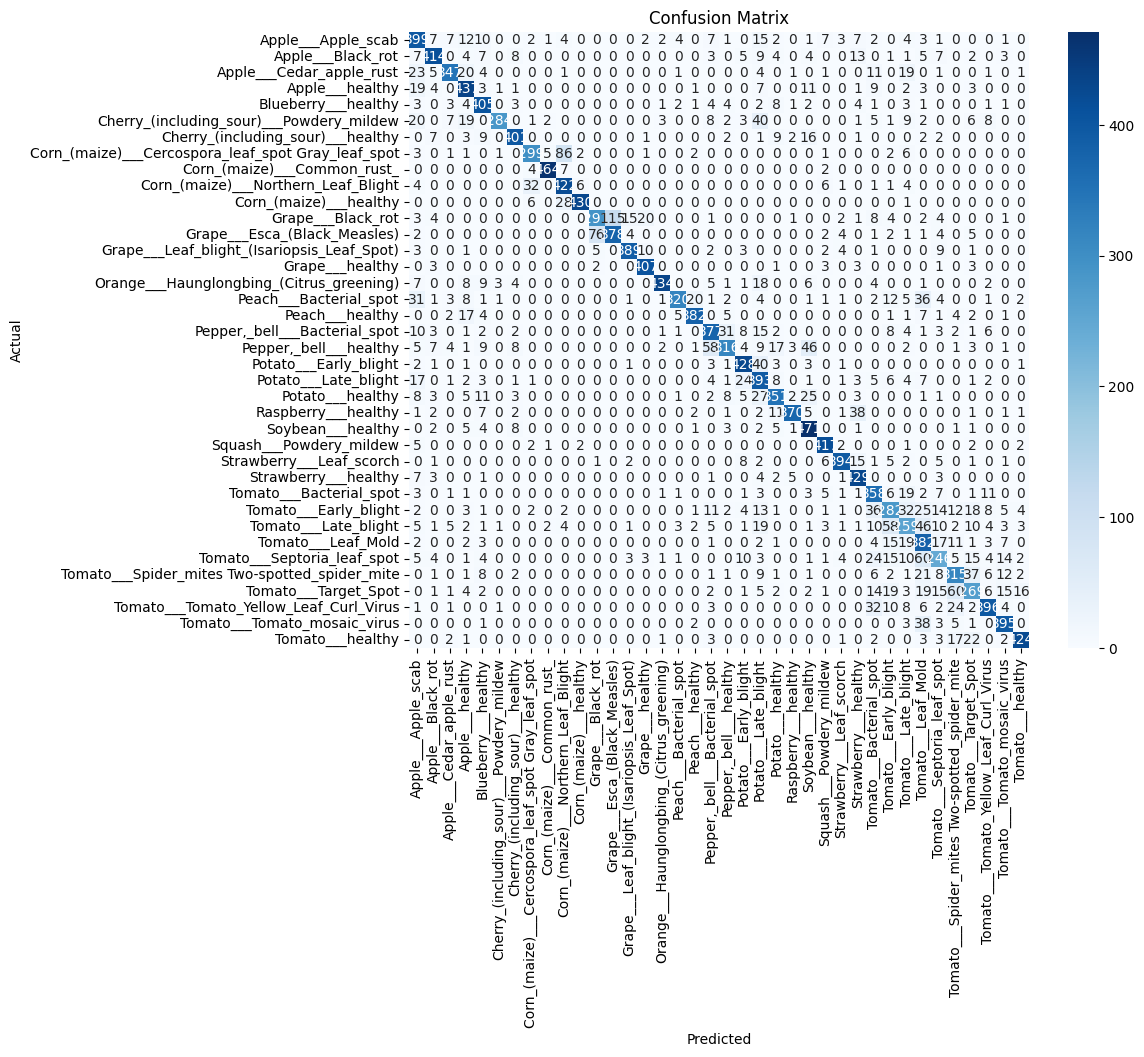

In [79]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


y_test_pred = VGG19_model.predict(test_generator)
y_test_pred_class = np.argmax(y_test_pred, axis=1) 


y_test_true = test_generator.classes


labels = list(test_generator.class_indices.keys())  # Class names


conf_matrix = confusion_matrix(y_test_true, y_test_pred_class)

#  Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Classification Report**

In [80]:
class_report = classification_report(y_test_true, y_test_pred_class, target_names=labels)
print('Classification Report:\n', class_report)

Classification Report:
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab       0.67      0.79      0.72       504
                                 Apple___Black_rot       0.87      0.83      0.85       497
                          Apple___Cedar_apple_rust       0.90      0.79      0.84       440
                                   Apple___healthy       0.77      0.87      0.82       502
                               Blueberry___healthy       0.80      0.89      0.84       454
          Cherry_(including_sour)___Powdery_mildew       0.97      0.67      0.80       421
                 Cherry_(including_sour)___healthy       0.91      0.88      0.89       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.86      0.73      0.79       410
                       Corn_(maize)___Common_rust_       0.98      0.97      0.97       477
               Corn_(maize)___Northern_Leaf_Blight     

**Save Model**

In [81]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_train_pred = VGG19_model.predict(train_generator)
y_test_pred = VGG19_model.predict(test_generator)

y_train_pred_class = np.argmax(y_train_pred, axis=1)
y_test_pred_class = np.argmax(y_test_pred, axis=1)

# Get the true class labels
y_train_true = train_generator.classes
y_test_true = test_generator.classes


f1_train = f1_score(y_train_true, y_train_pred_class, average='weighted')
f1_test = f1_score(y_test_true, y_test_pred_class, average='weighted')

989/989 ━━━━━━━━━━━━━━━━━━━━ 233s 236ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 65s 236ms/step


In [82]:
VGG19_results = {
    'model': 'ResNet',
    'Accuracy train': np.around(train_accuracy, 3),
    'Accuracy test': np.around(test_accuracy, 3),
    'Precision train': np.around(train_precision, 3),
    'Precision test': np.around(test_precision, 3),
    'Recall train': np.around(train_recall, 3),
    'Recall test': np.around(test_recall, 3),
    'F1-score train': np.around(f1_train, 3),
    'F1-score test': np.around(f1_test, 3)
}


VGG19_results

{'model': 'ResNet',
 'Accuracy train': 0.824,
 'Accuracy test': 0.805,
 'Precision train': 0.893,
 'Precision test': 0.883,
 'Recall train': 0.753,
 'Recall test': 0.737,
 'F1-score train': 0.026,
 'F1-score test': 0.804}

In [ ]:
metrics_df.loc[len(metrics_df)] = VGG19_results
metrics_df

In [76]:
metrics_df.to_csv('Results.csv', index=False)